## Trying to even figure out the drawing of the boundary

In [20]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.unfiltered_grid = self._create_environment()

        # TODO: The rest of your code 
        # PLACEHOLDERS to just make sure the code works
        self.observation_space = spaces.Box(low=0, high=3, dtype=np.int8)
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
        # It appears that there is no way to do 2 continuous and 1 discrete, might have to do the last float to be 0-0.33 to be Tree 0.34-0.66 to be Shrub etc
        # Yall have to research abit more
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        planting_grid, planting_coords  = self._filter_environment(planting_positions)

        return planting_grid, planting_coords, dithered_perlin_env


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def reset(self):
        self.grid, self.planting_coordinates, self.unfiltered_grid = self._create_environment()
        pass


    def step(self):
        pass

In [21]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customSpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(5)])


[0.26363423 0.14176004 0.2995702 ]
[6 6]


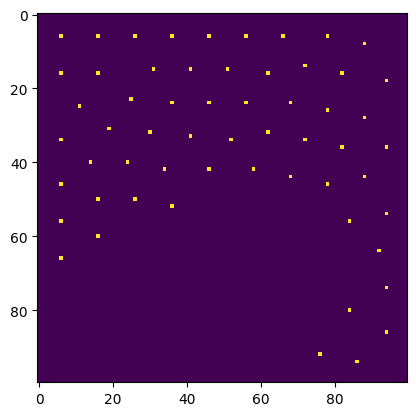

In [22]:
import matplotlib.pyplot as plt
# TEST EXAMPLE
test = customSpatialEnv(1.23)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
plt.imshow(test.grid) #grid

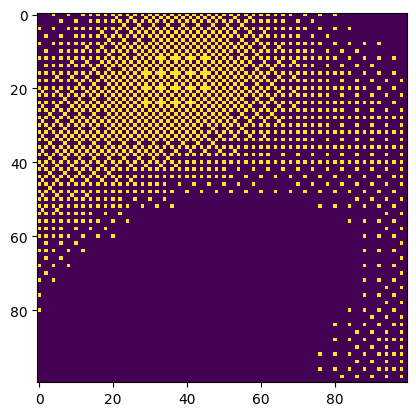

In [23]:
plt.imshow(test.unfiltered_grid)

In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_precise_boundary_no_approx(image_array, threshold_value=128, contour_color=(0, 255, 0), contour_thickness=1, dilation_iterations=4):
    '''
    Draws a precise boundary around all yellow regions in the given image without approximating contours.
    
    Parameters:
    - image_array: np.array -- the input image as a NumPy array.
    - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
    - contour_color: tuple -- the color of the boundary in BGR (default: green).
    - contour_thickness: int -- the thickness of the boundary (default: 1 for a thinner line).
    - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 1).
    
    Returns:
    - color_image: np.array -- the image with the drawn precise boundary.
    '''
    
    # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
    normalized_image = (image_array * 255).astype(np.uint8)

    # Apply a threshold to isolate the yellow area
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Optionally dilate the thresholded image to fill in gaps in the contours
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

    # Find contours on the thresholded image (we only want external contours)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Convert to color image (if not already)
    color_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

    # Draw the contours on the original image with the specified thickness
    cv2.drawContours(color_image, contours, -1, contour_color, contour_thickness)

    # Show the image with the precise boundary
    plt.imshow(color_image)
    plt.show()
    
    return color_image


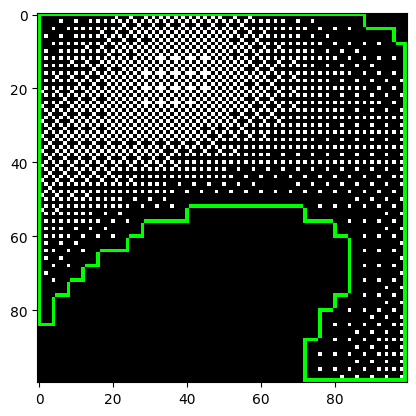

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [255, 255, 255],
        [  0, 255,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [76]:
draw_precise_boundary_no_approx(test.unfiltered_grid)

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_and_modify_array(image_array, threshold_value=128, contour_value=255, dilation_iterations=3):
    '''
    Draws a precise boundary around all yellow regions in the given image and updates the NumPy array with the boundary values.
    
    Parameters:
    - image_array: np.array -- the input image as a NumPy array.
    - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
    - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
    - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 1).
    
    Returns:
    - modified_array: np.array -- the modified NumPy array with the boundary values.
    '''
    
    # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
    normalized_image = (image_array * 255).astype(np.uint8)

    # Apply a threshold to isolate the yellow area
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Optionally dilate the thresholded image to fill in gaps in the contours
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

    # Find contours on the thresholded image (we only want external contours)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the original normalized image to modify it with the contours
    modified_array = np.copy(normalized_image)

    # Draw the contours on the array (modifying the array directly)
    cv2.drawContours(modified_array, contours, -1, contour_value, thickness=1)

    # Show the modified array with the contours
    plt.imshow(modified_array, cmap='gray')
    plt.show()
    
    return modified_array


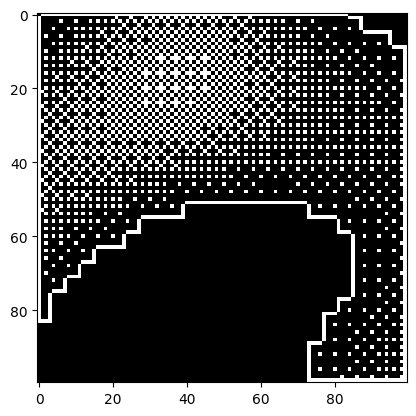

array([[  0, 255, 255, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [84]:
draw_and_modify_array(test.unfiltered_grid)

In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_and_return_boundary_only(image_array, threshold_value=128, contour_value=255, dilation_iterations=3):
    '''
    Draws a precise boundary around all yellow regions in the given image and returns an array with only the boundary values.
    
    Parameters:
    - image_array: np.array -- the input image as a NumPy array.
    - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
    - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
    - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
    
    Returns:
    - boundary_array: np.array -- the NumPy array containing only the boundary values.
    '''
    
    # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
    normalized_image = (image_array * 255).astype(np.uint8)

    # Apply a threshold to isolate the yellow area
    _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

    # Optionally dilate the thresholded image to fill in gaps in the contours
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

    # Find contours on the thresholded image (we only want external contours)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty array (same shape as normalized_image) to store only the boundary
    boundary_array = np.zeros_like(normalized_image)

    # Draw the contours on the boundary array (without the original regions, only the contours)
    cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

    # Show the boundary array
    plt.imshow(boundary_array, cmap='gray')
    plt.show()
    
    return boundary_array


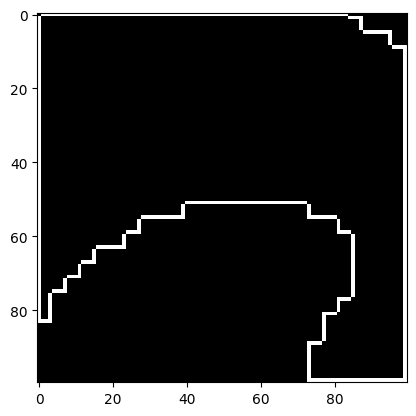

In [86]:
boundary_only_array = draw_and_return_boundary_only(test.unfiltered_grid)


## New Code with the boundary for now

In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.boundary = self._create_environment()

        # TODO: The rest of your code 
        # PLACEHOLDERS to just make sure the code works
        self.observation_space = spaces.Box(low=0, high=3, dtype=np.int8)
        self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
        # It appears that there is no way to do 2 continuous and 1 discrete, might have to do the last float to be 0-0.33 to be Tree 0.34-0.66 to be Shrub etc
        # Yall have to research abit more
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break


        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        

        return planting_grid, planting_coords, boundary


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def reset(self):
        self.grid, self.planting_coordinates, self.unfiltered_grid = self._create_environment()
        pass


    def step(self):
        pass

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr


In [8]:
from stable_baselines3.common.vec_env import DummyVecEnv

def make_env(octave):
    def _init():
        return customSpatialEnv(octave)
    return _init

# Example code for multiple environment, will make a list of 5 random environments
envs = DummyVecEnv([make_env(random.uniform(1,2)) for env in range(5)])


[0.08468413 0.6954699  0.02208634]
[ 6 14]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


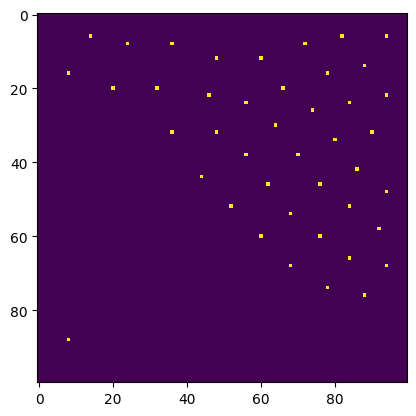

In [147]:
import matplotlib.pyplot as plt
# TEST EXAMPLE
test = customSpatialEnv(1.23)
print(test.action_space.sample()) #random action
print(test.planting_coordinates[0]) #coordinates
plt.imshow(test.grid) #grid
print(test.grid)

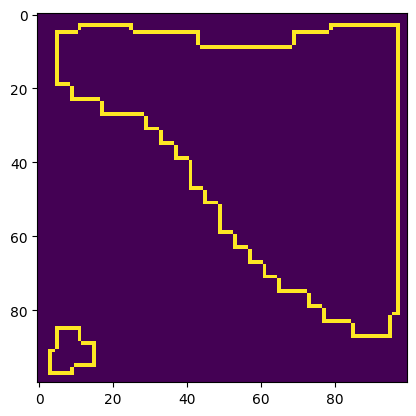

In [149]:
plt.imshow(test.boundary) #grid

## Step 2, Stable version combining the border and the planting spots

Things to do, 

define the action space, 

define the observation space, 

define the rewards, 

define the step for training

In [216]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt

# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.distances = self._create_environment() #0 for other area, 125 for planting spots, 255 for border

        plt.imshow(self.grid)
        print(self.planting_coordinates)
        print(self.distances)

        # TODO: The rest of your code 
        # PLACEHOLDERS to just make sure the code works

        self.plants = np.arange(1, 4) #Can put 3 values, 1, 2, 3 corresponds to Tree, Shrub, No plant

        self.action_space = spaces.MultiDiscrete([  # Action space for PPO
            len(self.plants),  # Choice of plants to be planted
        ])

        self.observation_space = spaces.Box(low=0, high=3, dtype=np.int8)
        # self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
        # It appears that there is no way to do 2 continuous and 1 discrete, might have to do the last float to be 0-0.33 to be Tree 0.34-0.66 to be Shrub etc
        # Yall have to research abit more
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def reset(self):
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        pass


    def step(self):
        pass

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy



[[ 6 14]
 [ 6 82]
 [ 6 94]
 [ 8 24]
 [ 8 36]
 [ 8 72]
 [12 48]
 [12 60]
 [14 88]
 [16  8]
 [16 78]
 [20 20]
 [20 32]
 [20 66]
 [22 46]
 [22 94]
 [24 56]
 [24 84]
 [26 74]
 [30 64]
 [32 36]
 [32 48]
 [32 90]
 [34 80]
 [38 56]
 [38 70]
 [42 86]
 [44 44]
 [46 62]
 [46 76]
 [48 94]
 [52 52]
 [52 84]
 [54 68]
 [58 92]
 [60 60]
 [60 76]
 [66 84]
 [68 68]
 [68 94]
 [74 78]
 [76 88]
 [88  8]]
[[0.7368421052631579, 0.05102040816326531], [0.05555555555555555, 0.8571428571428571], [0.7222222222222222, 0.4], [0.07575757575757576, 0.47058823529411764], [0.25757575757575757, 0.21621621621621623], [0.803030303030303, 0.12307692307692308], [0.3787878787878788, 0.26666666666666666], [0.5606060606060606, 0.22641509433962265], [0.9848484848484849, 0.03409090909090909], [0.34782608695652173, 0.37209302325581395], [0.7236842105263158, 0.2191780821917808], [0.7407407407407407, 0.12222222222222222], [0.06944444444444445, 0.6060606060606061], [0.5416666666666666, 0.3508771929824561], [0.2638888888888889, 0.53

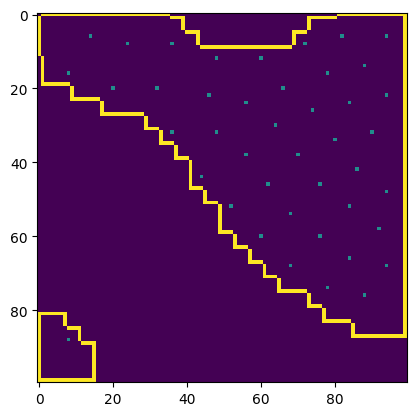

In [217]:
import matplotlib.pyplot as plt
# TEST EXAMPLE
test = customSpatialEnv(1.23)
# print(test.action_space.sample()) #random action
# print(test.planting_coordinates[0]) #coordinates
# plt.imshow(test.grid) #grid
# print(test.grid)

## Step 3, Trying to do training without the themeing\

In [227]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100), max_steps: int = 50):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w,h) of grid, defaults to (100,100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.distances = self._create_environment() #0 for other area, 125 for planting spots, 255 for border

        # TODO: The rest of your code 
        # PLACEHOLDERS to just make sure the code works

        self.plants = np.arange(1, 4) #Can put 3 values, 1, 2, 3 corresponds to Tree, Shrub, No plant

        self.action_space = spaces.Tuple((
            spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Random float for planting coordinate selection
            spaces.Discrete(len(self.plants))  # Choice of plants to be planted (Tree, Shrub, No plant)
        ))

        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })        # self.action_space = spaces.Box(low = 0, high = 1, shape = (3,), dtype = np.float32)
        # It appears that there is no way to do 2 continuous and 1 discrete, might have to do the last float to be 0-0.33 to be Tree 0.34-0.66 to be Shrub etc
        # Yall have to research abit more

        self.max_steps = max_steps
        self.current_step = 0  # Initialize step counter
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances


    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid


    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates


    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        
        Args:
            seed (int, optional): Seed for random number generation.
            options (dict, optional): Additional options.
        
        Returns:
            dict: The initial observation (grid and distances for the first planting spot).
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        initial_distances = self.distances[0] if len(self.planting_coordinates) > 0 else [0, 0]
        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid, 
            "horizontal_distance": horizontal_distance, 
            "vertical_distance": vertical_distance
        }, {}


    def step(self, action):
        random_float = action[0]  # The random float value
        plant_type = action[1]    # Plant type (0: Tree, 1: Shrub, 2: No plant)

        # Calculate the planting coordinate index based on the random float
        coord_index = int(np.floor(random_float * len(self.planting_coordinates)))

        # Get the planting coordinate based on the selected index
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Retrieve the distances for the selected planting coordinate
            distances = self.distances[coord_index]  # distances is a list of [vertical, horizontal]
            horizontal_distance, vertical_distance = distances[1], distances[0]

            # Define reward logic: Higher reward for planting farther from boundaries
            reward = 1  # Sum of the normalized distances (Top and Left)
        
        else:
            # Penalize for trying to plant on a non-plantable spot
            print("BIG ERROR")
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Check if all plantable spots are used (terminate the episode if all are planted)
        done = np.all(self.grid[self.grid == 125] != 125)

        info = {}  # Additional info can be added here

        # The truncated flag is set to False unless you want to enforce a max number of steps
        truncated = False  # Assuming no early truncation of episodes

        return observation, reward, done, truncated, info

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
def visualize_grid(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with planting and the distances from the borders.
    
    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.imshow(grid, cmap='gray')
    plt.title(f'Step: {step_count} | Horz Distance: {horizontal_distance[0]:.2f} | Vert Distance: {vertical_distance[0]:.2f}')
    plt.colorbar()
    plt.show()


def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    
    # Check the environment for any issues
    check_env(env, warn=True)

    # Create PPO model for training
    model = PPO("MultiInputPolicy", env, verbose=1)

    # Train the agent
    model.learn(total_timesteps=10000)

    # Evaluate the trained model
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

    # Visualize the grid after training
    obs = env.reset()
    for step in range(50):  # Simulate 50 steps
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

        # Visualize the grid and distances
        visualize_grid(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

        if done:
            print(f"Episode finished after {step+1} steps")
            break


if __name__ == "__main__":
    main()



c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\env_checker.py:122: UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
  warnings.warn(
c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
C:\Users\yongl\AppData\Local\Temp\ipykernel_20440\2187564962.py:205: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  co

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 2) + inhomogeneous part.

## Step 3a Unable to use a float to control the action space and ensure scalabiltiy so fuck it we chatgpt

c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47.8     |
|    ep_rew_mean     | 46.9     |
| time/              |          |
|    fps             | 199      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 47.7        |
|    ep_rew_mean          | 46.8        |
| time/                   |             |
|    fps                  | 175         |
|    iterations           | 2           |
|    time_elapsed         | 23          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.018385725 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss   

c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 45.3, Std reward: 5.1000000000000005
Step 1: Action = [62  2], Reward = 1
Step 2: Action = [15  1], Reward = 1
Step 3: Action = [64  2], Reward = 1
Step 4: Action = [8 0], Reward = 1
Step 5: Action = [93  0], Reward = 1
Step 6: Action = [32  0], Reward = 1
Step 7: Action = [68  2], Reward = 1
Step 8: Action = [86  1], Reward = 1
Step 9: Action = [68  0], Reward = 1
Step 10: Action = [2 0], Reward = 1
Step 11: Action = [21  1], Reward = 1
Step 12: Action = [31  0], Reward = 1
Step 13: Action = [45  1], Reward = 1
Step 14: Action = [22  1], Reward = 1
Step 15: Action = [38  1], Reward = 1
Step 16: Action = [86  1], Reward = 1
Step 17: Action = [5 0], Reward = 1
Step 18: Action = [45  2], Reward = 1
Step 19: Action = [85  2], Reward = 1
Step 20: Action = [92  2], Reward = 1
Step 21: Action = [70  0], Reward = 1
Step 22: Action = [85  0], Reward = 1
Step 23: Action = [94  0], Reward = 1
Step 24: Action = [63  1], Reward = 1
Step 25: Action = [58  1], Reward = 1
Step 26: Action

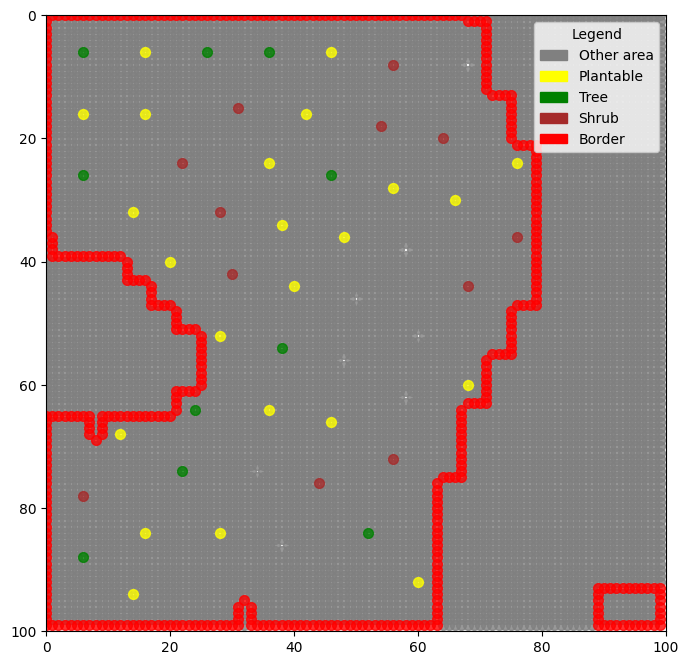

In [47]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100), max_steps: int = 50):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
            max_steps (int): Maximum number of steps (planting attempts) allowed per episode
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 3 for No plant
        self.plants = np.arange(1, 4)  # [Tree, Shrub, None]

        # Action space: Use MultiDiscrete for percentage and plant type
        self.action_space = spaces.MultiDiscrete([101, len(self.plants)])  # [0-100 for percentage, 3 for plant type]

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })

        # Maximum steps (planting attempts) allowed in the episode
        self.max_steps = max_steps
        self.current_step = 0  # Initialize step counter

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Reset step counter
        self.current_step = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        initial_distances = self.distances[0] if len(self.planting_coordinates) > 0 else [0, 0]
        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }, {}

    def step(self, action):
        # The action will contain two parts: percentage (0-100) and plant type
        percentage = action[0]  # Percentage value (0-100)
        plant_type = action[1]  # Plant type (0: Tree, 1: Shrub, 2: No plant)

        # Handle the case where there are no remaining plantable coordinates
        if len(self.planting_coordinates) == 0:
            terminated = True
            truncated = False
            reward = -1
            return {}, reward, terminated, truncated, {}

        # Convert the percentage to a valid planting coordinate index
        coord_index = int(np.floor((percentage / 100) *( len(self.planting_coordinates) - 1)))

        # Get the planting coordinate based on the selected index
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Retrieve the distances for the selected planting coordinate
            distances = self.distances[coord_index]  # distances is a list of [vertical, horizontal]
            horizontal_distance, vertical_distance = distances[1], distances[0]

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            # Define reward logic: Higher reward for planting farther from boundaries
            reward = 1  # Adjust as needed
        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Increment step counter
        self.current_step += 1

        # Check if the episode should end (either all steps used or all plantable spots planted)
        terminated = self.current_step >= self.max_steps

        # Truncated remains False
        truncated = False

        info = {}

        return observation, reward, terminated, truncated, info
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
import matplotlib.patches as mpatches

def visualize_grid_with_circles(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with circles representing different values and the distances from the borders.

    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles for each unique grid value
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area'},      # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable'},   # Plantable spots
        1: {'color': 'green', 'label': 'Tree'},           # Tree planted
        2: {'color': 'brown', 'label': 'Shrub'},          # Shrub planted
        255: {'color': 'red', 'label': 'Border'}          # Border (updated to red for better contrast)
    }

    # Get the unique values from the grid and plot circles accordingly
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=50, alpha=0.8)

    # Set titles and axis
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [mpatches.Patch(color=style['color'], label=f"{style['label']}") for style in marker_styles.values()]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.grid(False)
    plt.show()



def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    
    # Check the environment for any issues
    check_env(env, warn=True)

    # Create PPO model for training
    model = PPO("MultiInputPolicy", env, verbose=1)

    # Train the agent
    model.learn(total_timesteps=10000)

    # Save the trained model
    model.save("ppo_planting_model")

    # Evaluate the trained model
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

    # Visualize the grid after training
    obs, _ = env.reset()  # Adjust to get the observation without the info
    num_steps = 30
    for step in range(num_steps):  # Simulate 30 steps
        # Get the action from the model
        action, _states = model.predict(obs, deterministic=False)
        
        # Step in the environment
        obs, reward, terminated, truncated, info = env.step(action)
        
        # Print the action and reward
        print(f"Step {step + 1}: Action = {action}, Reward = {reward}")

        if step == num_steps - 1:
            # Visualize the grid and distances
            visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

        if terminated or truncated:
            print(f"Episode finished after {step + 1} steps")
            break

if __name__ == "__main__":
    main()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


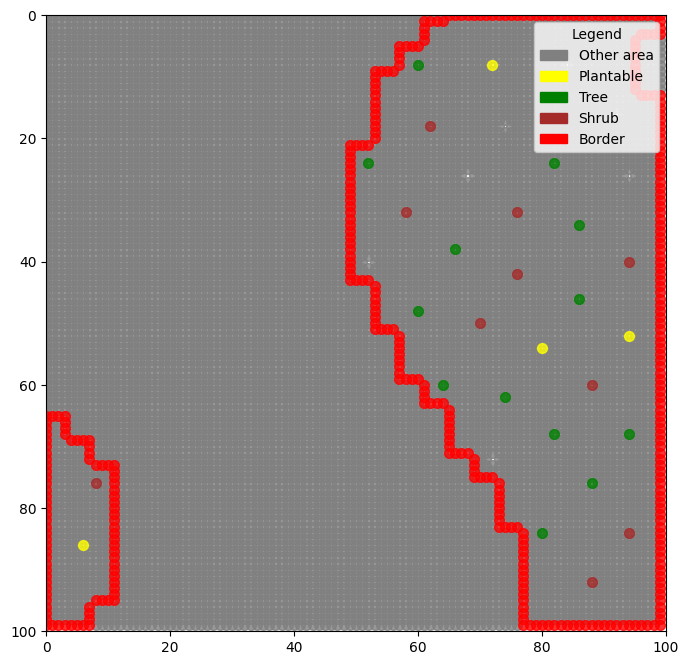

In [48]:
def generate_new_placement(env, model, num_steps=30):
    """
    Generate a new grid and use the model to place trees and shrubs.

    Args:
        env: The customSpatialEnv environment instance.
        model: The trained PPO model.
        num_steps: Number of steps to simulate planting.

    Returns:
        None, but visualizes the grid at the end of the process.
    """
    # Reset the environment to generate a new grid
    obs, _ = env.reset()  # Adjust to get the observation without the info
    
    # Simulate the planting process using the trained model
    for step in range(num_steps):
        # Use the model to predict the planting action
        action, _states = model.predict(obs, deterministic=False)
        
        # Perform the planting action in the environment
        obs, reward, terminated, truncated, info = env.step(action)
        
        # If it's the last step, visualize the final grid
        if step == num_steps - 1:
            visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

        # Terminate if the environment signals termination or truncation
        if terminated or truncated:
            print(f"Episode finished after {step+1} steps")
            break

# Main function
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    
    # Load the saved model
    model = PPO.load("ppo_planting_model", env=env)

    # Generate a new placement using the saved model and environment
    generate_new_placement(env, model, num_steps=30)


if __name__ == "__main__":
    main()


## Step 4 Tuning the reward function

We will be tuning the function for the sake of rewarding:

use of different placements,

not placing trees within 50 units of each other

In [308]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100), max_steps: int = 50):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
            max_steps (int): Maximum number of steps (planting attempts) allowed per episode
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 3 for No plant
        self.plants = np.arange(1, 4)  # [Tree, Shrub, None]

        # Action space: Use MultiDiscrete for percentage and plant type
        self.action_space = spaces.MultiDiscrete([101, 3])  # [0-100 for percentage, 0-2 for plant type]

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })

        # Maximum steps (planting attempts) allowed in the episode
        self.max_steps = max_steps
        self.current_step = 0  # Initialize step counter

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Reset step counter
        self.current_step = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }, {}

    def step(self, action):
        """
        The step function now takes a single action with two components:
        - action[0]: percentage_action (decides the planting location)
        - action[1]: plant_type_action (decides the type of plant)
        """
        # Extract the percentage and plant type from the action
        percentage = action[0]  # Percentage value (0-100)
        plant_type = action[1]  # Plant type (0: Tree, 1: Shrub, 2: No plant)

        # Handle the case where there are no remaining plantable coordinates
        if len(self.planting_coordinates) == 0:
            terminated = True
            truncated = False
            reward = -1
            return {}, reward, terminated, truncated, {}

        # Convert the percentage to a valid planting coordinate index
        coord_index = int(np.clip(np.floor((percentage / 100) * len(self.planting_coordinates)), 0, len(self.planting_coordinates) - 1))
        
        # Ensure valid index range, avoiding out-of-bounds
        coord_index = min(coord_index, len(self.planting_coordinates) - 1)

        # Get the planting coordinate based on the selected index
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)
            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            # Define reward logic: Higher reward for planting farther from boundaries
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0.5
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0.5
            balance_reward = 1 - (tree_proportion - shrub_proportion) ** 2

            distance_penalty = 0
            

            reward = balance_reward + distance_penalty

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                distances = self.distances[min(coord_index, len(self.distances) - 1)]  # distances is a list of [vertical, horizontal]
                horizontal_distance, vertical_distance = distances[1], distances[0]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Increment step counter
        self.current_step += 1

        # Check if the episode should end (either max steps used or all plantable spots planted)
        terminated = self.current_step >= self.max_steps

        # Truncated remains False
        truncated = False

        info = {}

        return observation, reward, terminated, truncated, info


    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
import matplotlib.patches as mpatches

def visualize_grid_with_circles(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with circles representing different values and the distances from the borders.

    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles for each unique grid value
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area'},      # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable'},   # Plantable spots
        1: {'color': 'green', 'label': 'Tree'},           # Tree planted
        2: {'color': 'brown', 'label': 'Shrub'},          # Shrub planted
        255: {'color': 'red', 'label': 'Border'}          # Border (updated to red for better contrast)
    }

    # Get the unique values from the grid and plot circles accordingly
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=50, alpha=0.8)

    # Set titles and axis
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [mpatches.Patch(color=style['color'], label=f"{style['label']}") for style in marker_styles.values()]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.grid(False)
    plt.show()


    
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Check the environment for any issues
    check_env(env, warn=True)

    # Create PPO model for training
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.01)

    # Train the agent
    model.learn(total_timesteps=10000)

    # Save the trained model
    model.save("ppo_planting_model")

    # Evaluate the trained model
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

    # Visualize the grid after training
    obs, _ = env.reset()  # Adjust to get the observation without the info
    num_steps = 30
    for step in range(num_steps):
        # Use non-deterministic action prediction to encourage exploration
        action, _states = model.predict(obs, deterministic=False)

        # Step with combined action
        obs, reward, terminated, truncated, info = env.step(action)

        print(f"Step {step + 1}: Reward = {reward}, Action = {action}")



if __name__ == "__main__":
    main()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47       |
|    ep_rew_mean     | 45.6     |
| time/              |          |
|    fps             | 173      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 46.7        |
|    ep_rew_mean          | 45.5        |
| time/                   |             |
|    fps                  | 162         |
|    iterations           | 2           |
|    time_elapsed         | 25          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019338723 |
|    clip_fraction        | 0.2         |
|    clip_range           | 0.2         |
|    entropy_loss   

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step 1: Reward = 0.0, Action = [100, 1]
Step 2: Reward = 1.0, Action = [100, 0]
Step 3: Reward = 0.8888888888888888, Action = [100, 0]
Step 4: Reward = 1.0, Action = [100, 1]
Step 5: Reward = 0.96, Action = [100, 0]
Step 6: Reward = 0.96, Action = [100, 2]
Step 7: Reward = 0.96, Action = [100, 2]
Step 8: Reward = 1.0, Action = [100, 1]
Step 9: Reward = 1.0, Action = [100, 2]
Step 10: Reward = 1.0, Action = [100, 2]
Step 11: Reward = 0.9795918367346939, Action = [100, 0]
Step 12: Reward = 1.0, Action = [100, 1]
Step 13: Reward = 1.0, Action = [100, 2]
Step 14: Reward = 0.9876543209876543, Action = [100, 0]
Step 15: Reward = 0.9876543209876543, Action = [100, 2]
Step 16: Reward = 0.96, Action = [100, 0]
Step 17: Reward = 0.9256198347107438, Action = [100, 0]
Step 18: Reward = 0.9722222222222222, Action = [100, 1]
Step 19: Reward = 0.9467455621301775, Action = [100, 0]
Step 20: Reward = 0.9467455621301775, Action

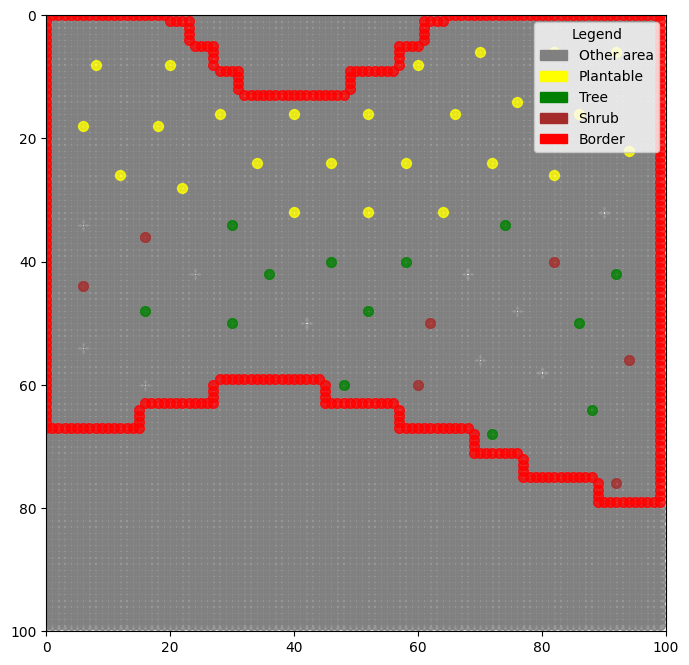

In [304]:
def generate_new_placement(env, model, num_steps=30):
    """
    Generate a new grid and use the model to place trees and shrubs.

    Args:
        env: The customSpatialEnv environment instance.
        model: The trained PPO model.
        num_steps: Number of steps to simulate planting.

    Returns:
        None, but visualizes the grid at the end of the process.
    """
    # Reset the environment to generate a new grid
    obs, _ = env.reset()  # Adjust to get the observation without the info
    
    # Simulate the planting process using the trained model
    for step in range(num_steps):
        # Use the model to predict the planting action
        percentage_action, _states = model.predict(obs, deterministic=True)
        
        # Randomly select the plant type for each step
        plant_type_action = random.choice([0, 1, 2])  # 0: Tree, 1: Shrub, 2: No plant
        
        # Combine the two actions into a single action
        combined_action = [percentage_action[0], plant_type_action]
        
        # Perform the planting action in the environment
        obs, reward, terminated, truncated, info = env.step(combined_action)
        
        # Print step details
        print(f"Step {step + 1}: Reward = {reward}, Action = {combined_action}")

        # If it's the last step, visualize the final grid
        if step == num_steps - 1:
            visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

        # Terminate if the environment signals termination or truncation
        if terminated or truncated:
            print(f"Episode finished after {step + 1} steps")
            break

# Main function
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    
    # Load the saved model
    model = PPO.load("ppo_planting_model", env=env)

    # Generate a new placement using the saved model and environment
    generate_new_placement(env, model, num_steps=30)

if __name__ == "__main__":
    main()


### Changing action between each plant

reward function, now implementing the distance

In [342]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100), max_steps: int = 50):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
            max_steps (int): Maximum number of steps (planting attempts) allowed per episode
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 3 for No plant
        self.plants = np.arange(1, 4)  # [Tree, Shrub, None]

        # Action space: Use MultiDiscrete for percentage and plant type
        self.action_space = spaces.MultiDiscrete([101, 3])  # [0-100 for percentage, 0-2 for plant type]

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })

        # Maximum steps (planting attempts) allowed in the episode
        self.max_steps = max_steps
        self.current_step = 0  # Initialize step counter

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Reset step counter
        self.current_step = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains two parts:
        - action[0]: percentage (0-100) for selecting the planting coordinate.
        - action[1]: plant type (0: Tree, 1: Shrub, 2: No plant).
        """
        # Unpack the action
        percentage_action = action[0]
        plant_type_action = action[1]

        # The rest of your existing step logic...
        percentage = percentage_action  # Percentage value (0-100)
        plant_type = plant_type_action  # Plant type (0: Tree, 1: Shrub, 2: No plant)

        # Handle the case where there are no remaining plantable coordinates
        if len(self.planting_coordinates) == 0:
            terminated = True
            truncated = False
            reward = -1
            return {}, reward, terminated, truncated, {}

        # Convert the percentage to a valid planting coordinate index
        coord_index = int(np.clip(np.floor((percentage / 100) * len(self.planting_coordinates)), 0, len(self.planting_coordinates) - 1))
        
        # Ensure valid index range, avoiding out-of-bounds
        coord_index = min(coord_index, len(self.planting_coordinates) - 1)

        # Get the planting coordinate based on the selected index
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions for distance penalty

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            # Calculate the balance reward (trees vs shrubs)
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0.5
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0.5
            balance_reward = 1 - abs(tree_proportion - shrub_proportion)

            # Distance penalty for trees planted too closely together
            distance_penalty = 0
            if self.plants[plant_type] == 1:  # Only apply penalty for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):  # Ensure we don't penalize the same tree
                        continue
                    # Calculate Euclidean distance between trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # Penalty for planting within 50 units
                        distance_penalty -= 0.2

            # Total reward = balance_reward + distance_penalty
            reward = balance_reward + distance_penalty

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                distances = self.distances[min(coord_index, len(self.distances) - 1)]  # distances is a list of [vertical, horizontal]
                horizontal_distance, vertical_distance = distances[1], distances[0]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Increment step counter
        self.current_step += 1

        # Check if the episode should end (either max steps used or all plantable spots planted)
        terminated = self.current_step >= self.max_steps

        # Truncated remains False
        truncated = False

        info = {}

        return observation, reward, terminated, truncated, info


    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
import matplotlib.patches as mpatches

def visualize_grid_with_circles(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with circles representing different values and the distances from the borders.

    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles for each unique grid value
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area'},      # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable'},   # Plantable spots
        1: {'color': 'green', 'label': 'Tree'},           # Tree planted
        2: {'color': 'brown', 'label': 'Shrub'},          # Shrub planted
        255: {'color': 'red', 'label': 'Border'}          # Border (updated to red for better contrast)
    }

    # Get the unique values from the grid and plot circles accordingly
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=50, alpha=0.8)

    # Set titles and axis
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [mpatches.Patch(color=style['color'], label=f"{style['label']}") for style in marker_styles.values()]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.grid(False)
    plt.show()


    
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Check the environment for any issues
    check_env(env, warn=True)

    # Create PPO model for training
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.01)

    # Train the agent
    model.learn(total_timesteps=10000)

    # Save the trained model
    model.save("ppo_planting_model")

    # Evaluate the trained model
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

    # Visualize the grid after training
    obs, _ = env.reset()  # Adjust to get the observation without the info
    num_steps = 30
    for step in range(num_steps):
        # Use non-deterministic action prediction to encourage exploration
        action, _states = model.predict(obs, deterministic=False)

        # Step with combined action
        obs, reward, terminated, truncated, info = env.step(action)

        print(f"Step {step + 1}: Reward = {reward}, Action = {action}")



if __name__ == "__main__":
    main()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.8     |
|    ep_rew_mean     | -504     |
| time/              |          |
|    fps             | 152      |
|    iterations      | 1        |
|    time_elapsed    | 13       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 48          |
|    ep_rew_mean          | -864        |
| time/                   |             |
|    fps                  | 127         |
|    iterations           | 2           |
|    time_elapsed         | 32          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010991404 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss   

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step 1: Reward = 0.0, Action = [56, 0]
Step 2: Reward = 0.0, Action = [56, 2]
Step 3: Reward = 0.0, Action = [56, 2]
Step 4: Reward = 0.0, Action = [56, 2]
Step 5: Reward = 0.0, Action = [56, 2]
Step 6: Reward = 0.0, Action = [56, 2]
Step 7: Reward = 1.0, Action = [56, 1]
Step 8: Reward = 0.46666666666666673, Action = [56, 0]
Step 9: Reward = 0.6666666666666667, Action = [56, 2]
Step 10: Reward = 0.09999999999999998, Action = [56, 0]
Step 11: Reward = 0.8, Action = [56, 1]
Step 12: Reward = 1.0, Action = [56, 1]
Step 13: Reward = 0.2571428571428571, Action = [56, 0]
Step 14: Reward = 0.8571428571428572, Action = [56, 2]
Step 15: Reward = 1.0, Action = [56, 1]
Step 16: Reward = 0.8888888888888888, Action = [56, 1]
Step 17: Reward = 0.8888888888888888, Action = [56, 2]
Step 18: Reward = 0.8888888888888888, Action = [56, 2]
Step 19: Reward = 0.19999999999999996, Action = [56, 0]
Step 20: Reward = -0.0909090909090

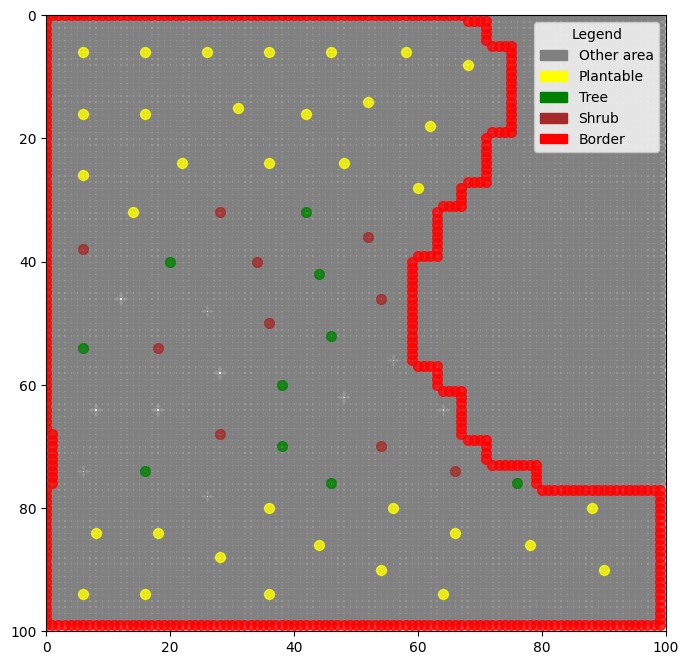

In [343]:
def generate_new_placement(env, model, num_steps=30):
    """
    Generate a new grid and use the model to place trees and shrubs.

    Args:
        env: The customSpatialEnv environment instance.
        model: The trained PPO model.
        num_steps: Number of steps to simulate planting.

    Returns:
        None, but visualizes the grid at the end of the process.
    """
    # Reset the environment to generate a new grid
    obs, _ = env.reset()  # Adjust to get the observation without the info
    
    # Simulate the planting process using the trained model
    for step in range(num_steps):
        # Use the model to predict the planting action
        percentage_action, _states = model.predict(obs, deterministic=True)
        
        # Randomly select the plant type for each step
        plant_type_action = random.choice([0, 1, 2])  # 0: Tree, 1: Shrub, 2: No plant
        
        # Combine the two actions into a single action
        combined_action = [percentage_action[0], plant_type_action]
        
        # Perform the planting action in the environment
        obs, reward, terminated, truncated, info = env.step(combined_action)
        
        # Print step details
        print(f"Step {step + 1}: Reward = {reward}, Action = {combined_action}")

        # If it's the last step, visualize the final grid
        if step == num_steps - 1:
            visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

        # Terminate if the environment signals termination or truncation
        if terminated or truncated:
            print(f"Episode finished after {step + 1} steps")
            break

# Main function
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    
    # Load the saved model
    model = PPO.load("ppo_planting_model", env=env)

    # Generate a new placement using the saved model and environment
    generate_new_placement(env, model, num_steps=30)

if __name__ == "__main__":
    main()


### Changing to tryin for every unplantable spot

In [2]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 3 for No plant
        self.plants = np.arange(1, 4)  # [Tree, Shrub, None]

        # Action space: Use MultiDiscrete for percentage and plant type
        self.action_space = spaces.MultiDiscrete([101, 3])  # [0-100 for percentage, 0-2 for plant type]

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains two parts:
        - action[0]: percentage (0-100) for selecting the planting coordinate.
        - action[1]: plant type (0: Tree, 1: Shrub, 2: No plant).
        """
        # Unpack the action
        percentage_action = action[0]
        plant_type_action = action[1]

        # The rest of your existing step logic...
        percentage = percentage_action  # Percentage value (0-100)
        plant_type = plant_type_action  # Plant type (0: Tree, 1: Shrub, 2: No plant)

        # Handle the case where there are no remaining plantable coordinates
        if len(self.planting_coordinates) == 0:
            terminated = True
            truncated = False
            reward = -1
            return {}, reward, terminated, truncated, {}

        # Convert the percentage to a valid planting coordinate index
        coord_index = int(np.clip(np.floor((percentage / 100) * len(self.planting_coordinates)), 0, len(self.planting_coordinates) - 1))
        
        # Ensure valid index range, avoiding out-of-bounds
        coord_index = min(coord_index, len(self.planting_coordinates) - 1)

        # Get the planting coordinate based on the selected index
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions for distance penalty

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            # Calculate the balance reward (trees vs shrubs)
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0.5
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0.5
            balance_reward = np.exp(tree_proportion) - (tree_proportion - shrub_proportion) ** 2

            # Distance penalty for trees planted too closely together
            distance_penalty = 0
            if self.plants[plant_type] == 1:  # Only apply penalty for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):  # Ensure we don't penalize the same tree
                        continue
                    # Calculate Euclidean distance between trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # Penalty for planting within 50 units
                        distance_penalty -= np.exp(tree_proportion) ** 2

            # Total reward = balance_reward + distance_penalty
            reward = balance_reward + distance_penalty

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                distances = self.distances[min(coord_index, len(self.distances) - 1)]  # distances is a list of [vertical, horizontal]
                horizontal_distance, vertical_distance = distances[1], distances[0]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {}

        return observation, reward, terminated, truncated, info
    
    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
import matplotlib.patches as mpatches

def visualize_grid_with_circles(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with circles representing different values and the distances from the borders.

    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles for each unique grid value
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area'},      # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable'},   # Plantable spots
        1: {'color': 'green', 'label': 'Tree'},           # Tree planted
        2: {'color': 'brown', 'label': 'Shrub'},          # Shrub planted
        255: {'color': 'red', 'label': 'Border'}          # Border (updated to red for better contrast)
    }

    # Get the unique values from the grid and plot circles accordingly
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=50, alpha=0.8)

    # Set titles and axis
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [mpatches.Patch(color=style['color'], label=f"{style['label']}") for style in marker_styles.values()]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.grid(False)
    plt.show()
    
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Check the environment for any issues
    check_env(env, warn=True)

    # # Create PPO model for training
    # model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.01)

    # # Train the agent
    # model.learn(total_timesteps=10000)

    # # Save the trained model
    # model.save("ppo_planting_model")

    # # Evaluate the trained model
    # mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    # print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

    # # Visualize the grid after training
    # obs, _ = env.reset()  # Adjust to get the observation without the info
    # step = 0
    # while True:
    #     # Use non-deterministic action prediction to encourage exploration
    #     action, _states = model.predict(obs, deterministic=False)

    #     # Step with combined action
    #     obs, reward, terminated, truncated, info = env.step(action)

    #     step += 1
    #     print(f"Step {step}: Reward = {reward}, Action = {action}")

    #     if terminated or truncated:
    #         print(f"Episode finished after {step} steps")
    #         break


if __name__ == "__main__":
    main()

c:\Users\yongl\anaconda3\envs\Spatial\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation grid has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step 1: Reward = 0.0, Action = [89, 1]
Step 2: Reward = 0.0, Action = [89, 2]
Step 3: Reward = 1.6487212707001282, Action = [89, 0]
Step 4: Reward = 1.2845013139749784, Action = [89, 1]
Step 5: Reward = 1.2845013139749784, Action = [89, 2]
Step 6: Reward = 1.2845013139749784, Action = [89, 2]
Step 7: Reward = 1.0340254166877414, Action = [89, 1]
Step 8: Reward = 1.4518246976412703, Action = [89, 0]
Step 9: Reward = 1.4518246976412703, Action = [89, 2]
Step 10: Reward = -1.0695605577589173, Action = [89, 0]
Step 11: Reward = -1.3853279743999738, Action = [84, 0]
Step 12: Reward = 1.7503867891698488, Action = [84, 2]
Step 13: Reward = -5.17493995749146, Action = [84, 0]
Step 14: Reward = -5.750712859422791, Action = [84, 0]
Step 15: Reward = 1.8366229299435646, Action = [84, 2]
Step 16: Reward = -10.31184719306355, Action = [84, 0]
Step 17: Reward = 1.8537527074704767, Action = [84, 2]
Step 18: Reward = -19.5498

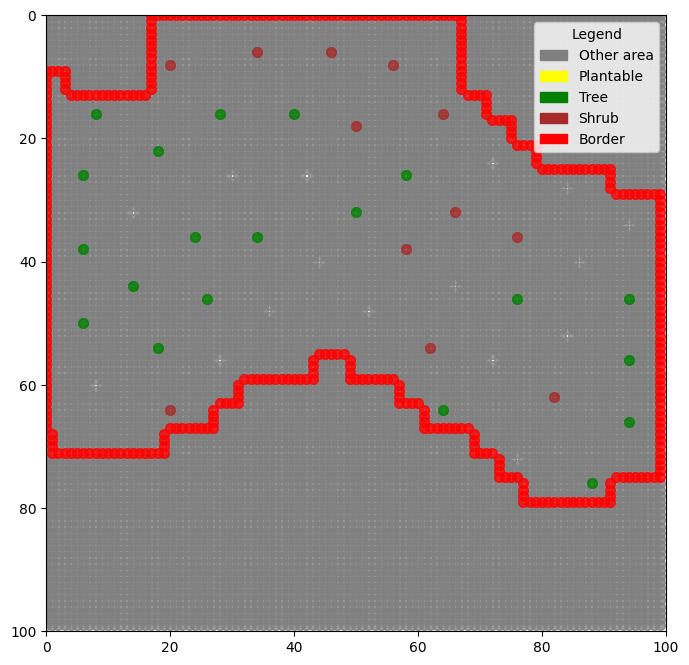

In [7]:
def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees and shrubs until all plantable spots are used.

    Args:
        env: The customSpatialEnv environment instance.
        model: The trained PPO model.

    Returns:
        None, but visualizes the grid at the end of the process.
    """
    # Reset the environment to generate a new grid
    obs, _ = env.reset()  # Adjust to get the observation without the info
    
    step = 0  # Initialize step counter

    # Continue until the environment signals termination (no more plantable spots)
    while True:
        # Use the model to predict the planting action
        percentage_action, _states = model.predict(obs, deterministic=True)
        
        # Randomly select the plant type for each step
        plant_type_action = random.choice([0, 1, 2])  # 0: Tree, 1: Shrub, 2: No plant
        
        # Combine the two actions into a single action
        combined_action = [percentage_action[0], plant_type_action]
        
        # Perform the planting action in the environment
        obs, reward, terminated, truncated, info = env.step(combined_action)
        
        # Print step details
        step += 1
        print(f"Step {step}: Reward = {reward}, Action = {combined_action}")

        # If the environment signals termination (no more plantable spots), end the episode
        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    # Visualize the final grid after all plantable spots are used
    visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

# Main function
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    
    # Load the saved model
    model = PPO.load("ppo_planting_model", env=env)

    # Generate a new placement using the saved model and environment
    generate_new_placement(env, model)

if __name__ == "__main__":
    main()


## Step 5: Change the action space to be distance base and select the closest plant spotting accordingly

Ideally at this step

In [67]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.max_attempts = 100000  # Maximum number of attempts
        self.attempt_counter = 0  # Tracks the number of attempts

        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 3 for No plant
        self.plants = np.arange(1, 3)  # [Tree, Shrub]

        # Action space: Use MultiDiscrete for percentage and plant type
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1).
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "grid": self.grid,
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = -20  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "grid": self.grid,
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Otherwise, reward based on how close the selection is to the nearest plantable spot
        else:
            reward = 1 - diff / 100


        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.5:
            plant_type = 0  # Tree
        else:
            plant_type = 1  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions for distance penalty

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            # Calculate the balance reward (trees vs shrubs)
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = (self.num_trees) / (total_plants) if total_plants > 0 else 0.5
            shrub_proportion = (self.num_shrubs) / total_plants if total_plants > 0 else 0.5
            balance_reward = 0
            shrub_bias = 0.1  # Adjust shrub bias to increase the reward for more shrubs

            # Calculate the reward with bias towards shrubs
            if shrub_proportion > tree_proportion:
                balance_reward = 1 + shrub_bias * (shrub_proportion - tree_proportion)
            else:
                balance_reward = 1 - (tree_proportion - shrub_proportion)/100
            # Distance penalty for trees planted too closely together
            distance_penalty = 0
            if self.plants[plant_type] == 1:  # Only apply penalty for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):  # Ensure we don't penalize the same tree
                        continue
                    # Calculate Euclidean distance between trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # Penalty for planting within 50 units
                        distance_penalty -= 10

            # Total reward = balance_reward + distance_penalty + distance-based reward
            reward += balance_reward + distance_penalty

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                distances = self.distances[min(coord_index, len(self.distances) - 1)]  # distances is a list of [vertical, horizontal]
                horizontal_distance, vertical_distance = distances[1], distances[0]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
import matplotlib.patches as mpatches

def visualize_grid_with_circles(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with circles representing different values and the distances from the borders.

    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles for each unique grid value
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area'},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable'},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree'},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub'},  # Shrub planted
    }


    # Get the unique values from the grid and plot circles accordingly
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=50, alpha=0.8)

    # Set titles and axis
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [mpatches.Patch(color=style['color'], label=f"{style['label']}") for style in marker_styles.values()]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.grid(False)
    plt.show()
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=50000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model


# Main function to load, train, and test the model
def main():
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Check environment
    check_env(env, warn=True)

    # Load and train the model, but don't save it yet
    model = load_model(env)
    model = train_model(env)

    # Render one episode to test the model before deciding to save
    model = render_episode(env, model)

    # Return the model so it can be used for further testing and saving later
    return model

if __name__ == "__main__":
    model = main()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 465      |
|    ep_rew_mean     | -1.7e+04 |
| time/              |          |
|    fps             | 1104     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 533         |
|    ep_rew_mean          | -2.96e+04   |
| time/                   |             |
|    fps                  | 800         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007631302 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss   

Step 1: Reward = 2.019785478214862, Action = [0.5785173736034489, 0.24358684833327887, 1.0]
Step 2: Reward = -20, Action = [0.024613179625642446, 0.11443732892211594, 0.0]
Step 3: Reward = -20, Action = [0.03555323631619899, 0.23079299977890075, 0.0]
Step 4: Reward = -20, Action = [0.0, 0.04814243546379909, 0.0]
Step 5: Reward = 2.015802362899848, Action = [0.6662534206009223, 0.0, 0.8697615373015868]
Step 6: Reward = -20, Action = [0.0, 0.07558155253901806, 0.33137997772920275]
Step 7: Reward = -20, Action = [0.021926465641065637, 0.0, 0.0]
Step 8: Reward = -20, Action = [0.0757223580130005, 0.06278954300724847, 0.9747045324726511]
Step 9: Reward = 1.9658359213500127, Action = [0.0, 1.0, 0.9986577197418138]
Step 10: Reward = -20, Action = [1.0, 0.0, 0.7676208093460906]
Step 11: Reward = -20, Action = [0.06258858620427808, 0.0096790822129613, 0.045896959532396364]
Step 12: Reward = -20, Action = [0.003564114586029307, 0.062026053777112594, 0.6232517480780884]
Step 13: Reward = -20, Act

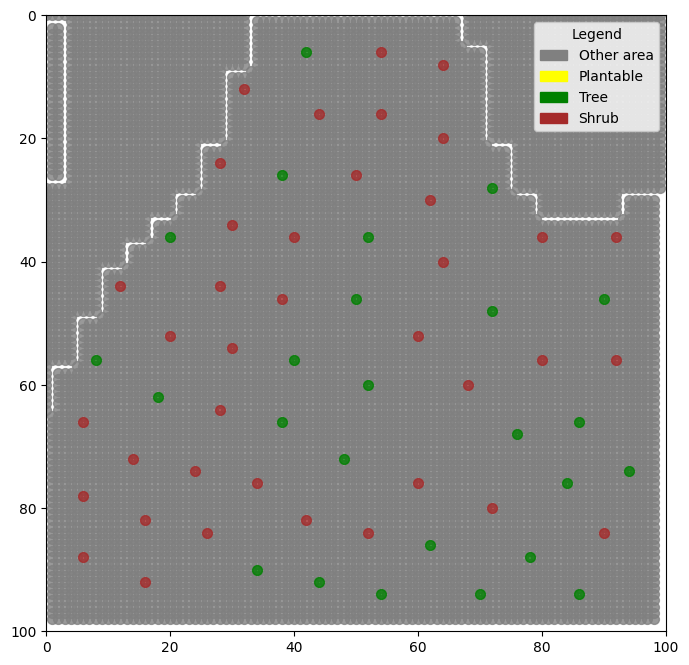

In [70]:
import numpy as np

def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees and shrubs until all plantable spots are used.

    Args:
        env: The customSpatialEnv environment instance.
        model: The trained PPO model.

    Returns:
        None, but visualizes the grid at the end of the process.
    """
    # Reset the environment to generate a new grid
    obs, _ = env.reset()  # Adjust to get the observation without the info
    
    step = 0  # Initialize step counter

    # Continue until the environment signals termination (no more plantable spots)
    while True:
        # Use the model to predict the planting action
        action, _states = model.predict(obs, deterministic=False)  # Keep deterministic=False for exploration
        
        # Add noise/randomness to the model's predicted actions for exploration
        noise = np.random.normal(0, 0.05, size=action.shape)  # Random noise with mean=0, std_dev=0.05
        randomized_action = action + noise
        
        # Ensure the randomized actions are clipped to stay within the valid range [0, 1]
        randomized_action = np.clip(randomized_action, 0, 1)
        
        # The model now outputs three continuous values (0 to 1) with added randomness
        horizontal_ratio = randomized_action[0]  # Corresponds to the horizontal planting coordinate
        vertical_ratio = randomized_action[1]    # Corresponds to the vertical planting coordinate
        plant_type_selector = randomized_action[2]  # Determines plant type (Tree, Shrub, or No Plant)

        # Combine the ratios into an action (horizontal, vertical, plant type)
        combined_action = [horizontal_ratio, vertical_ratio, plant_type_selector]
        
        # Perform the planting action in the environment
        obs, reward, terminated, truncated, info = env.step(combined_action)
        
        # Print step details
        step += 1
        print(f"Step {step}: Reward = {reward}, Action = {combined_action}")

        # If the environment signals termination (no more plantable spots), end the episode
        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    # Visualize the final grid after all plantable spots are used
    visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

# Main function
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Assuming the model is already available in the 'model' variable
    # Generate a new placement using the current model and environment
    generate_new_placement(env, model)

if __name__ == "__main__":
    main()


In [8]:
model.save("models/Model1")

## Step 6: adding penalty for shrub density above x% and also trying to change to a full positive system

Try putting low values and more focus on positive values

In [123]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors



# Environment Class
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.max_attempts = 100000  # Maximum number of attempts
        self.attempt_counter = 0  # Tracks the number of attempts

        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 3 for No plant
        self.plants = np.arange(1, 3)  # [Tree, Shrub]

        # Action space: Use MultiDiscrete for percentage and plant type
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "grid": spaces.Box(low=0, high=255, shape=self.grid_size, dtype=np.uint8),   # Grid with values between 0 and 255
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)    # Vertical distance (top)
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Initial observation
        return {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1).
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "grid": self.grid,
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "grid": self.grid,
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.5:
            plant_type = 0  # Tree
        else:
            plant_type = 1  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub, 3: None)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions for distance penalty

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            # Calculate the balance reward (trees vs shrubs)
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = (self.num_trees) / (total_plants) if total_plants > 0 else 0.5
            shrub_proportion = (self.num_shrubs) / total_plants if total_plants > 0 else 0.5
            balance_reward = 0

            balance_reward = 1 - (tree_proportion - 0.25 *shrub_proportion)/100
            # Distance penalty for trees planted too closely together

            distance_reward = 0.5

            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                min_dist = float('inf')  # Initialize minimum distance to a large value

                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):  # Ensure we don't compare the same tree
                        continue
                    # Calculate Euclidean distance between trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    min_dist = min(min_dist, dist)  # Track the minimum distance to any tree

                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if min_dist <= 50:
                    distance_reward = (min_dist / 50)**2  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 1

            # Total reward = balance_reward + distance_penalty + distance-based reward
            reward += 2 * balance_reward + 2 * distance_reward

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                distances = self.distances[min(coord_index, len(self.distances) - 1)]  # distances is a list of [vertical, horizontal]
                horizontal_distance, vertical_distance = distances[1], distances[0]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        # Observation: the current state of the environment (grid and distances for the selected point)
        observation = {
            "grid": self.grid,
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        # cleaned_environemnt= self._set_array_borders(dithered_perlin_env)
        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy
    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model


# Main function to load, train, and test the model
def main():
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Check environment
    check_env(env, warn=True)

    # Load and train the model, but don't save it yet
    model = load_model(env)
    model = train_model(env)

    # Render one episode to test the model before deciding to save
    model = render_episode(env, model)

    # Return the model so it can be used for further testing and saving later
    return model

if __name__ == "__main__":
    model = main()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 517      |
|    ep_rew_mean     | 119      |
| time/              |          |
|    fps             | 1071     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 516          |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 789          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0063284314 |
|    clip_fraction        | 0.0594       |
|    clip_range           | 0.2          |
|    en

Episode finished after 622 steps


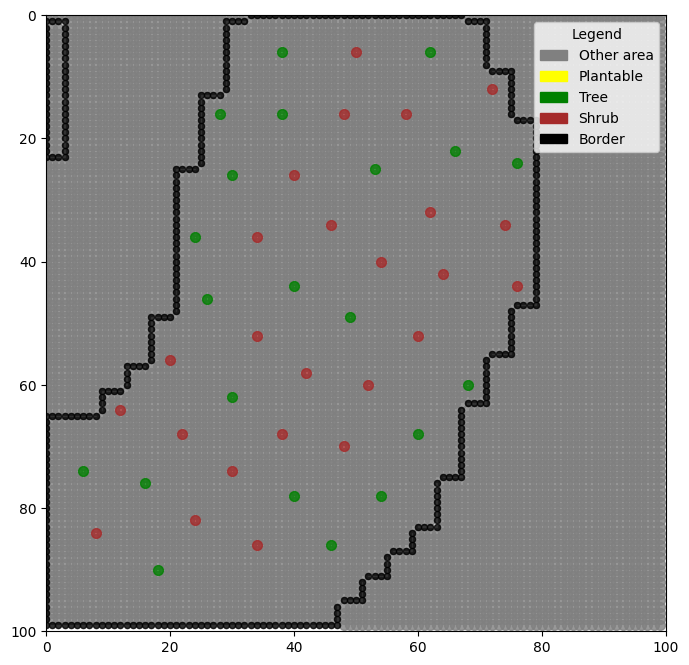

In [133]:
import numpy as np

import matplotlib.patches as mpatches

def visualize_grid_with_circles(grid, horizontal_distance, vertical_distance, step_count):
    """
    Visualize the grid with circles representing different values and the distances from the borders.

    Args:
        grid (np.ndarray): The current grid with plantable spots, borders, etc.
        horizontal_distance (float): Distance from the left border for the selected point.
        vertical_distance (float): Distance from the top border for the selected point.
        step_count (int): Current step number for visualization.
    """
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Define the marker styles for each unique grid value
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},  # Other areas (not plantable)
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},  # Plantable spots
        1: {'color': 'green', 'label': 'Tree', 'size': 50},  # Tree planted
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},  # Shrub planted
        255: {'color': 'black', 'label': 'Border', 'size': 20},  # Border area (set to black, smaller size)
    }

    # Get the unique values from the grid and plot circles accordingly
    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)  # Get coordinates where this value exists
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    # Set titles and axis
    plt.xlim(0, grid.shape[1])
    plt.ylim(0, grid.shape[0])
    plt.gca().invert_yaxis()  # Invert Y-axis to match the grid representation

    # Create a legend
    handles = [mpatches.Patch(color=style['color'], label=f"{style['label']}") for style in marker_styles.values()]
    plt.legend(handles=handles, title="Legend", loc='upper right')

    plt.grid(False)
    plt.show()


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees and shrubs until all plantable spots are used.

    Args:
        env: The customSpatialEnv environment instance.
        model: The trained PPO model.

    Returns:
        None, but visualizes the grid at the end of the process.
    """
    # Reset the environment to generate a new grid
    obs, _ = env.reset()  # Adjust to get the observation without the info
    
    step = 0  # Initialize step counter

    # Continue until the environment signals termination (no more plantable spots)
    while True:
        # Use the model to predict the planting action
        action, _states = model.predict(obs, deterministic=False)  # Keep deterministic=False for exploration
        
        # Add noise/randomness to the model's predicted actions for exploration
        noise = np.random.normal(0, 0.05, size=action.shape)  # Random noise with mean=0, std_dev=0.05
        randomized_action = action + noise
        
        # Ensure the randomized actions are clipped to stay within the valid range [0, 1]
        randomized_action = np.clip(randomized_action, 0, 1)
        
        # The model now outputs three continuous values (0 to 1) with added randomness
        horizontal_ratio = randomized_action[0]  # Corresponds to the horizontal planting coordinate
        vertical_ratio = randomized_action[1]    # Corresponds to the vertical planting coordinate
        plant_type_selector = randomized_action[2]  # Determines plant type (Tree, Shrub, or No Plant)

        # Combine the ratios into an action (horizontal, vertical, plant type)
        combined_action = [horizontal_ratio, vertical_ratio, plant_type_selector]
        
        # Perform the planting action in the environment
        obs, reward, terminated, truncated, info = env.step(combined_action)
        
        # Print step details
        step += 1
        # print(f"Step {step}: Reward = {reward}, Action = {combined_action}")

        # If the environment signals termination (no more plantable spots), end the episode
        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    # Visualize the final grid after all plantable spots are used
    visualize_grid_with_circles(obs['grid'], obs['horizontal_distance'], obs['vertical_distance'], step)

# Main function
def main():
    # Instantiate the environment
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))

    # Assuming the model is already available in the 'model' variable
    # Generate a new placement using the current model and environment
    generate_new_placement(env, model)

if __name__ == "__main__":
    main()


Generations tried:

Higher ratio of balance, with weight towards shrub: Mostly 50-50 in number of trees selected

Balanced Ratio: Still no difference

Trying to use square in the distance balancing to encourage further placement

In [130]:
model.save("models/")

Now trying to incorpoorate distance from border into training the model into the reward as well

## Step 7: Possibly use tensorboard to record the values